# Sources and inspiration 

https://developers.google.com/machine-learning/crash-course/california-housing-data-description

# Loading all the necessary libraries

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('project_005/housing.csv')
X,y  = df.loc[:,df.columns != 'median_house_value'] , df.loc[:,'median_house_value']
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,INLAND


# Exploring the Data

## Understanding the Features 

`longitude` : A measure of how far west a house is; a more negative value is farther west

`latitude` : A measure of how far north a house is; a higher value is farther north

`housing_median_age` : Median age of a house within a block; a lower number is a newer building

`total_rooms` : Total number of rooms within a block

`total_bedrooms` : Total number of bedrooms within a block

`population` : Total number of people residing within a block

`households` : Total number of households, a group of people residing within a home unit, for a block

`median_income` : Median income for households within a block of houses (measured in tens of thousands of US Dollars)

`median_house_value` : Median house value for households within a block (measured in US Dollars) [target value]

In [12]:
print(df.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


`ocean_proximity` : Categorical Value that represents the proximity to the ocean 

In [14]:
X['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Ideas for feature engineering 
`number of bedrooms per person ` : `total_bedrooms` / `population` 

`number of rooms per person ` : `total_rooms` / `population` 

`number of rooms per household ` : `total_rooms` / `households`

`how big the house value in comparaison to median income` : `median_house_value` / `median_income` 

`ocean_proximity` : could be Ordinal Encoded 

## Looking for columns with null data
_total_bedrooms_ contains missing values, that could be replaced with the mean

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


In [4]:
X.isna().sum()
X['total_bedrooms']

0         129.0
1        1106.0
2         190.0
3         235.0
4         280.0
          ...  
20635     374.0
20636     150.0
20637     485.0
20638     409.0
20639     616.0
Name: total_bedrooms, Length: 20640, dtype: float64

In [5]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


## Looking for columns with fewer values 
_ocean_proximity_ represents categorical values that should be HotEncoded  

In [7]:
X.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
ocean_proximity           5
dtype: int64

## Looking for duplicates 

In [8]:
dups = X.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(X[dups])

False
Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []


## Exploring Correlations 

In [15]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Histograms representing the data 

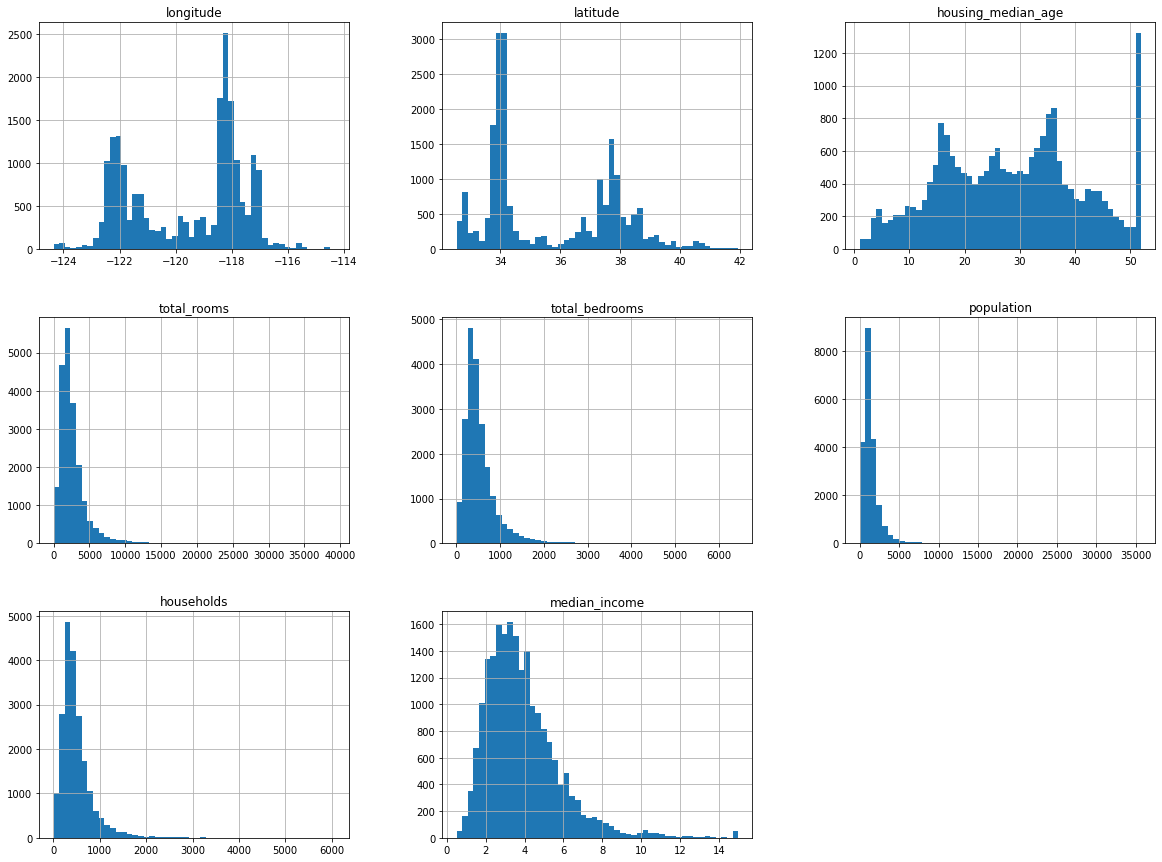

In [16]:
X.hist(bins=50, figsize=(20,15))
plt.show()

## Feature Engineering 

In [19]:
df['n_bedrooms_per_person'] = df['total_bedrooms'] / df['population']
df['n_rooms_per_person'] = df['total_rooms'] / df['population']
df['n_rooms_per_household'] = df['total_rooms'] / df['households']

In [21]:
## Re-Exploring Correlations 

In [22]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending= False)

median_house_value       1.000000
median_income            0.688075
n_rooms_per_person       0.209482
n_rooms_per_household    0.151948
total_rooms              0.134153
housing_median_age       0.105623
n_bedrooms_per_person    0.069896
households               0.065843
total_bedrooms           0.049686
population              -0.024650
longitude               -0.045967
latitude                -0.144160
Name: median_house_value, dtype: float64

# Applying Transformations 
List of transformations that could be considered :
- Completion of missing values in total_bedrooms 
- HotEncode ocean_proximity 
- Detect Outliers 
- Apply a Feature selection method 

In [11]:
num_cols = list(X.columns)
num_cols.remove('ocean_proximity')


numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('poly' , 'passthrough'),
        ('std_scaler', StandardScaler()),
        ('minmax_scaler', MinMaxScaler())
    ])

categorical_pipeline = Pipeline([
    ("hot_encoder", OneHotEncoder()) 
])


final_pipeline = ColumnTransformer([
    ('num_pip', numerical_pipeline, num_cols),
    ('cat_pip', categorical_pipeline, ['ocean_proximity'])
    ])



full_pipeline_with_predictor = Pipeline([
        ("data_prep",final_pipeline ),
        ("model", 'passthrough'),
        
    ])

full_pipeline_with_predictor.fit(X, y)

full_pipeline_with_predictor.get_params()

{'memory': None,
 'steps': [('data_prep',
   ColumnTransformer(transformers=[('num_pip',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('poly', 'passthrough'),
                                                    ('std_scaler',
                                                     StandardScaler()),
                                                    ('minmax_scaler',
                                                     MinMaxScaler())]),
                                    ['longitude', 'latitude', 'housing_median_age',
                                     'total_rooms', 'total_bedrooms', 'population',
                                     'households', 'median_income']),
                                   ('cat_pip',
                                    Pipeline(steps=[('hot_encoder',
                                                

## Linear Regression 

In [12]:
normal_params = {
    'data_prep__num_pip__imputer__strategy' : ['mean', 'median', 'most_frequent', 'constant'] ,
    'data_prep__num_pip__std_scaler': ['passthrough', StandardScaler()],
    'data_prep__num_pip__minmax_scaler': ['passthrough',MinMaxScaler()],
    'data_prep__num_pip__poly' : [PolynomialFeatures(degree) for degree in range(1,2)] 
}
linreg_models = {"model": [Ridge(),Lasso(max_iter = 10000)],
             "model__alpha": [0.01,0.1,1,5,10,20,30]}


params = [{**normal_params,**linreg_models}]

grid_params = params

gs = GridSearchCV(full_pipeline_with_predictor, grid_params, scoring='r2', verbose=2)


X_train, X_test, y_train, y_test = train_test_split(X, y)
# run gridsearch
gs.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', gs.best_params_)
print('Grid best score (accuracy): ', gs.best_score_)

gs.best_estimator_.score(X_test,y_test)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_s

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV]

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.804e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.7s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.7s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.805e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Las

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Las

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; tot

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; tot

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10;

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30;

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.804e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.805e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardSc

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardSc

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=Standar

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=pass

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01;

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; tot

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total ti

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total t

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total t

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.805e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.760e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.1s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.834e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.806e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.8s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.5s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, 

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, 

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthroug

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardSc

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge()

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), mode

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), mode

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.8s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.805e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.7s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.760e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.9s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.834e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.8s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.806e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scale

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scale

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_sc

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_sc

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=mean, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), mode

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total 

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, mode

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, mode

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, m

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, m

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alph

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alph

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__a

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__a

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.9s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   2.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   2.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.9s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   4.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   2.5s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=St

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=St

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; tot

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; tot

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10;

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30;

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   2.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   2.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.759e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.805e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.3s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passt

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passt

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=pa

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardS

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(),

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   2.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   2.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.8s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.759e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.8s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.7s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.805e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.8s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.5s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__s

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__s

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=median, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Rid

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), mod

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), mod

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), 

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), 

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.802e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.5s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pi

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pi

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardSc

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler()

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScale

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScale

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.1s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.802e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.7s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.8s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.9s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.1s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), da

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1),

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough,

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, mo

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, mod

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, mod

C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.760e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.826e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   2.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.837e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.804e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.2s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=1; total time=   0.2s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_pre

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_pre

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scal

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=Stan

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=Stan

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=S

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=S

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=S

C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.3s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.835e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.01; total time=   2.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.760e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.9s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.826e+12, tolerance: 1.641e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.837e+12, tolerance: 1.653e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.804e+12, tolerance: 1.648e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=0.1; total time=   1.6s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.5s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.4s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=1; total time=   0.3s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degr

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=5; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degr

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=10; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(d

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=most_frequent, data_prep__num_pip__minmax_scaler=MinMaxScaler(), data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=StandardScaler(), model=Lasso(max_iter=10000), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.01; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=0.1

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=1; total t

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=20; tot

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 457, in predict
    Xt = transform.transform(Xt)
  File "C:\Users\dell\anaconda3\lib\site-

[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s
[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Ridge(), model__alpha=30; total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.765e+12, tolerance: 1.639e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.869e+12, tolerance: 1.645e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(

[CV] END data_prep__num_pip__imputer__strategy=constant, data_prep__num_pip__minmax_scaler=passthrough, data_prep__num_pip__poly=PolynomialFeatures(degree=1), data_prep__num_pip__std_scaler=passthrough, model=Lasso(max_iter=10000), model__alpha=0.01; total time=   1.4s


KeyboardInterrupt: 

## RandomForestRegressor 
### On smaller number of estimators 

In [13]:



linreg_models = {"model": [RandomForestRegressor()],
             "model__n_estimators": [3, 10, 30,60,100], 'model__max_features': [2, 4, 6, 8,10,12,14]}


params = [{**linreg_models}]

grid_params = params

gs = GridSearchCV(full_pipeline_with_predictor, grid_params, scoring='r2', verbose=2)


X_train, X_test, y_train, y_test = train_test_split(X, y)
# run gridsearch
gs.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', gs.best_params_)
print('Grid best score (accuracy): ', gs.best_score_)

gs.best_estimator_.score(X_test,y_test)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5; 1/35] START model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3
[CV 1/5; 1/35] END model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3;, score=0.723 total time=   0.0s
[CV 2/5; 1/35] START model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3
[CV 2/5; 1/35] END model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3;, score=0.686 total time=   0.1s
[CV 3/5; 1/35] START model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3
[CV 3/5; 1/35] END model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3;, score=0.686 total time=   0.0s
[CV 4/5; 1/35] START model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3
[CV 4/5; 1/35] END model=RandomForestRegressor(), model__max_features=2, model__n_estimators=3;, score=0.697 total time=   0.0s
[CV 5/5; 1/35] START model=RandomFores

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 3/5; 31/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=3;, score=nan total time=   0.0s
[CV 4/5; 31/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=3
[CV 4/5; 31/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=3;, score=nan total time=   0.0s
[CV 5/5; 31/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=3
[CV 5/5; 31/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=3;, score=nan total time=   0.0s
[CV 1/5; 32/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10
[CV 1/5; 32/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10;, score=nan total time=   0.0s
[CV 2/5; 32/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 2/5; 32/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10;, score=nan total time=   0.0s
[CV 3/5; 32/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10
[CV 3/5; 32/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10;, score=nan total time=   0.0s
[CV 4/5; 32/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10
[CV 4/5; 32/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10;, score=nan total time=   0.0s
[CV 5/5; 32/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10
[CV 5/5; 32/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=10;, score=nan total time=   0.0s
[CV 1/5; 33/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 1/5; 33/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30;, score=nan total time=   0.0s
[CV 2/5; 33/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30
[CV 2/5; 33/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30;, score=nan total time=   0.0s
[CV 3/5; 33/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30
[CV 3/5; 33/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30;, score=nan total time=   0.0s
[CV 4/5; 33/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30
[CV 4/5; 33/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30;, score=nan total time=   0.0s
[CV 5/5; 33/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=30
[CV 5/5; 33/35] END model=RandomForestRegressor(), model__max_features=14, model__n_

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 1/5; 34/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60;, score=nan total time=   0.0s
[CV 2/5; 34/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60
[CV 2/5; 34/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60;, score=nan total time=   0.0s
[CV 3/5; 34/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60
[CV 3/5; 34/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60;, score=nan total time=   0.0s
[CV 4/5; 34/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 4/5; 34/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60;, score=nan total time=   0.0s
[CV 5/5; 34/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60
[CV 5/5; 34/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=60;, score=nan total time=   0.0s
[CV 1/5; 35/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100
[CV 1/5; 35/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 2/5; 35/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100
[CV 2/5; 35/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 35/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100
[CV 3/5; 35/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 35/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 4/5; 35/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 35/35] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100
[CV 5/5; 35/35] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69747234 0.77326319 0.79220827 0.7962465  0.79954175 0.72372284
 0.79006504 0.80868016 0.81199267 0.81408434 0.74163507 0.79814206
 0.81226662 0.81651659 0.81726617 0.74512696 0.79624505 0.815254
 0.81761438 0.81951554 0.74592864 0.80158464 0.8123307  0.8176721
 0.81831254 0.74586264 0.7970014  0.81292215 0.81601116 0.81693189
        nan        nan        nan        nan        nan]
  warnings.warn(


Grid best parameter (max. accuracy):  {'model': RandomForestRegressor(max_features=8), 'model__max_features': 8, 'model__n_estimators': 100}
Grid best score (accuracy):  0.8195155371839729


0.8196633360220554

### On a bigger number of estimators 

In [15]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split


linreg_models = {"model": [RandomForestRegressor()],
             "model__n_estimators": [100,200,300,400,500], 'model__max_features': [8,10,12,14]}


params = [{**linreg_models}]

grid_params = params

gs = GridSearchCV(full_pipeline_with_predictor, grid_params, scoring='r2', verbose=10)


X_train, X_test, y_train, y_test = train_test_split(X, y)
# run gridsearch
gs.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', gs.best_params_)
print('Grid best score (accuracy): ', gs.best_score_)

gs.best_estimator_.score(X_test,y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100
[CV 1/5; 1/20] END model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100;, score=0.824 total time=   6.5s
[CV 2/5; 1/20] START model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100
[CV 2/5; 1/20] END model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100;, score=0.806 total time=   6.0s
[CV 3/5; 1/20] START model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100
[CV 3/5; 1/20] END model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100;, score=0.826 total time=   6.2s
[CV 4/5; 1/20] START model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100
[CV 4/5; 1/20] END model=RandomForestRegressor(), model__max_features=8, model__n_estimators=100;, score=0.817 total time=   6.9s
[CV 5/5; 1/20] START m

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 3/5; 16/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 16/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100
[CV 4/5; 16/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 16/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 5/5; 16/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 17/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200
[CV 1/5; 17/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200;, score=nan total time=   0.0s
[CV 2/5; 17/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 2/5; 17/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200;, score=nan total time=   0.0s
[CV 3/5; 17/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200
[CV 3/5; 17/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200;, score=nan total time=   0.0s
[CV 4/5; 17/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 4/5; 17/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200;, score=nan total time=   0.0s
[CV 5/5; 17/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200
[CV 5/5; 17/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=200;, score=nan total time=   0.0s
[CV 1/5; 18/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 1/5; 18/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300;, score=nan total time=   0.1s
[CV 2/5; 18/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 2/5; 18/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300;, score=nan total time=   0.1s
[CV 3/5; 18/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300
[CV 3/5; 18/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300;, score=nan total time=   0.1s
[CV 4/5; 18/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 4/5; 18/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300;, score=nan total time=   0.1s
[CV 5/5; 18/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 5/5; 18/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=300;, score=nan total time=   0.1s
[CV 1/5; 19/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 1/5; 19/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400;, score=nan total time=   0.1s
[CV 2/5; 19/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 2/5; 19/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400;, score=nan total time=   0.1s
[CV 3/5; 19/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 3/5; 19/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400;, score=nan total time=   0.2s
[CV 4/5; 19/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 4/5; 19/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400;, score=nan total time=   0.1s
[CV 5/5; 19/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 5/5; 19/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=400;, score=nan total time=   0.1s
[CV 1/5; 20/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 1/5; 20/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500;, score=nan total time=   0.1s
[CV 2/5; 20/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 2/5; 20/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500;, score=nan total time=   0.2s
[CV 3/5; 20/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 3/5; 20/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500;, score=nan total time=   0.2s
[CV 4/5; 20/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 4/5; 20/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500;, score=nan total time=   0.2s
[CV 5/5; 20/20] START model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500


C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dell\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

[CV 5/5; 20/20] END model=RandomForestRegressor(), model__max_features=14, model__n_estimators=500;, score=nan total time=   0.3s
Grid best parameter (max. accuracy):  {'model': RandomForestRegressor(max_features=8, n_estimators=300), 'model__max_features': 8, 'model__n_estimators': 300}
Grid best score (accuracy):  0.8210809626706987


0.8220765866099548

In [16]:
gs.best_estimator_

Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('num_pip',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   'passthrough'),
                                                                  ('std_scaler',
                                                                   StandardScaler()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                   

In [18]:
import joblib 

joblib.dump(gs.best_estimator_, 'project_005/random_forest_best.pkl')

['project_005/random_forest_best.pkl']

In [19]:
random_forest = joblib.load('project_005/random_forest_best.pkl')

In [20]:
random_forest

Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('num_pip',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   'passthrough'),
                                                                  ('std_scaler',
                                                                   StandardScaler()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                   